# SEMMA — Titanic (All-in-One)
**Date:** 2025-11-02

- Runs **Sample → Explore → Modify → Model → Assess** in one notebook.
- Saves figures to `./assets/` and displays them inline.
- If `data/raw/train.csv` is present, uses it; otherwise generates a realistic synthetic demo dataset.

In [1]:

# Setup & Utilities
import os, json, math, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, accuracy_score, brier_score_loss,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from scipy import stats

SEED = 42
TARGET = "Survived"
ID_COL = "PassengerId"

os.makedirs("assets", exist_ok=True)
os.makedirs("reports", exist_ok=True)

def savefig(path):
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight")
    print(f"Saved figure → {path}")


## Stage 1 — Sample
70/15/15 **group-aware** (by `Ticket_norm`) split with fixed seed; stratification on target is approximated via group splits.

In [2]:

def load_titanic():
    # Try local Kaggle CSV; else synthesize a plausible dataset
    for fn in ["data/raw/train.csv","train.csv","titanic.csv"]:
        if os.path.exists(fn):
            df = pd.read_csv(fn)
            # Normalize column names to match expectations where possible
            return df, False
    rng = np.random.default_rng(SEED)
    n=800
    pid=np.arange(1,n+1)
    pclass = rng.choice([1,2,3], n, p=[0.24,0.20,0.56])
    sex = rng.choice(["male","female"], n, p=[0.65,0.35])
    titles = np.where(sex=="female", rng.choice(["Mrs","Miss"], n, p=[0.55,0.45]),
                      rng.choice(["Mr","Master","Dr"], n, p=[0.88,0.10,0.02]))
    last = rng.choice(["Smith","Johnson","Brown","Taylor","Williams","Davies","Miller","Wilson","Moore","Clark"], n)
    first = rng.choice(["John","James","William","Charles","George","Henry","Arthur","Albert","Edward","Robert",
                        "Mary","Anna","Elizabeth","Margaret","Florence","Ethel"], n)
    name = [f"{l}, {t}. {f}" for l,t,f in zip(last,titles,first)]
    age = rng.normal(30,14,n).clip(0,80); age[rng.random(n)<0.2]=np.nan
    sibsp = rng.poisson(0.5,n).clip(0,8); parch = rng.poisson(0.4,n).clip(0,6)
    fare = np.round(np.exp(rng.normal(3.0,0.8,n))-5,2); fare[fare<0]=0.0
    embarked = rng.choice(["S","C","Q"], n, p=[0.72,0.18,0.10])
    cabin = np.array([None]*n, dtype=object)
    ticket = rng.integers(100000,999999,n).astype(str)
    prob = 0.38 + 0.18*(sex=="female").astype(float) + 0.10*(pclass==1) - 0.06*(pclass==3)
    prob += np.where(~np.isnan(age)&(age<15), 0.15, 0.0); prob = np.clip(prob,0.02,0.98)
    y = rng.binomial(1,prob).astype(int)
    df = pd.DataFrame({"PassengerId":pid,"Survived":y,"Pclass":pclass,"Name":name,"Sex":sex,
                       "Age":age,"SibSp":sibsp,"Parch":parch,"Ticket":ticket,"Fare":fare,
                       "Cabin":cabin,"Embarked":embarked})
    return df, True

def normalize_ticket(s):
    return (str(s).replace(" ", "")).upper()

def sample_stage(df):
    df = df.copy()
    df["Ticket_norm"] = df["Ticket"].astype(str).str.replace(r"\s+","",regex=True).str.replace(r"[^A-Za-z0-9]","",regex=True).str.upper()
    # Group-aware split ~ keeps ticket groups disjoint
    gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
    idx_tv, idx_te = next(gss.split(df, groups=df["Ticket_norm"]))
    tv, te = df.iloc[idx_tv], df.iloc[idx_te]
    gss2 = GroupShuffleSplit(n_splits=1, test_size=0.15/(1-0.15), random_state=SEED)
    idx_tr, idx_va = next(gss2.split(tv, groups=tv["Ticket_norm"]))
    tr, va = tv.iloc[idx_tr], tv.iloc[idx_va]
    # Integrity
    assert set(tr["Ticket_norm"]).isdisjoint(va["Ticket_norm"])
    assert set(tr["Ticket_norm"]).isdisjoint(te["Ticket_norm"])
    assert set(va["Ticket_norm"]).isdisjoint(te["Ticket_norm"])
    return tr.reset_index(drop=True), va.reset_index(drop=True), te.reset_index(drop=True)

df, demo_mode = load_titanic()
train_df, val_df, test_df = sample_stage(df)

summary = pd.DataFrame({
    "split":["train","val","test"],
    "rows":[len(train_df), len(val_df), len(test_df)],
    "pos_rate":[train_df[TARGET].mean(), val_df[TARGET].mean(), test_df[TARGET].mean()],
    "groups":[train_df["Ticket_norm"].nunique(), val_df["Ticket_norm"].nunique(), test_df["Ticket_norm"].nunique()]
})
print("Demo mode:", demo_mode)
summary


Demo mode: True


,split,rows,pos_rate,groups
0,train,559,0.438283,559
1,val,120,0.366667,120
2,test,121,0.545455,120


## Stage 2 — Explore
Missingness, correlations, Cramér’s V (categoricals), leakage cues, and key distributions.

Saved figure → assets/missingness_train.png


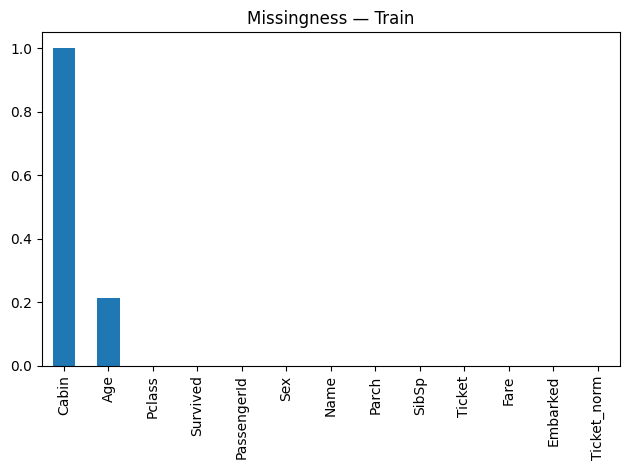

In [3]:

# Missingness bar (train)
miss = train_df.isna().mean().sort_values(ascending=False)
plt.figure()
miss.plot(kind="bar")
plt.title("Missingness — Train")
savefig("assets/missingness_train.png")
plt.show()


Saved figure → assets/corr_heatmap_train.png


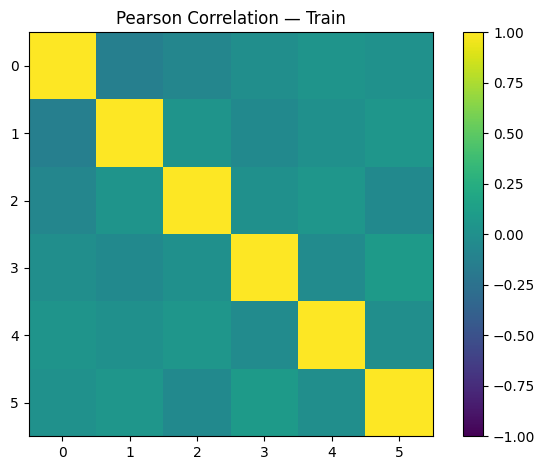

In [4]:

# Pearson correlation among numeric (train)
num = train_df.select_dtypes(include=[np.number]).drop(columns=[ID_COL], errors="ignore")
corr = num.corr(method="pearson")
plt.figure()
plt.imshow(corr, vmin=-1, vmax=1)
plt.title("Pearson Correlation — Train")
plt.colorbar()
savefig("assets/corr_heatmap_train.png")
plt.show()


In [5]:

# Cramér's V of categoricals vs target
def cramers_v(x,y):
    ct = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(ct)[0]
    n = ct.values.sum()
    phi2 = chi2 / n
    r, k = ct.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    denom = max(1e-9, min((kcorr-1),(rcorr-1)))
    return float(np.sqrt(phi2corr / denom))

cat_cols = train_df.select_dtypes(exclude=[np.number]).columns.tolist()
rows=[]
for c in cat_cols:
    try:
        rows.append({"feature":c, "cramers_v": cramers_v(train_df[c].astype(str), train_df[TARGET])})
    except Exception:
        pass
cv_df = pd.DataFrame(rows).sort_values("cramers_v", ascending=False)
cv_df


,feature,cramers_v
1,Sex,0.129812
0,Name,0.021859
2,Ticket,0.000000
3,Cabin,0.000000
4,Embarked,0.000000
5,Ticket_norm,0.000000


In [6]:

# Leakage cues: Cabin first letter distribution; Ticket prefixes
leak_info = {}
leak_info["cabin_first_letter"] = train_df["Cabin"].astype(str).str[0].value_counts().head(10).to_dict()
leak_info["ticket_prefix"] = train_df["Ticket"].astype(str).str.replace(r"\d+","",regex=True).str.strip().replace("", "NONE").value_counts().head(10).to_dict()
print(json.dumps(leak_info, indent=2))


{
  "cabin_first_letter": {
    "N": 559
  },
  "ticket_prefix": {
    "NONE": 559
  }
}


In [7]:

# Target balance by Sex and Pclass (fairness sanity / drift cue)
grp = train_df.groupby(["Sex","Pclass"])[TARGET].mean().reset_index().pivot(index="Sex", columns="Pclass", values=TARGET)
grp


Pclass,1,2,3
Sex,,,
female,0.638298,0.512195,0.495327
male,0.500000,0.430769,0.325359


Saved figure → assets/age_hist_survived_0.png


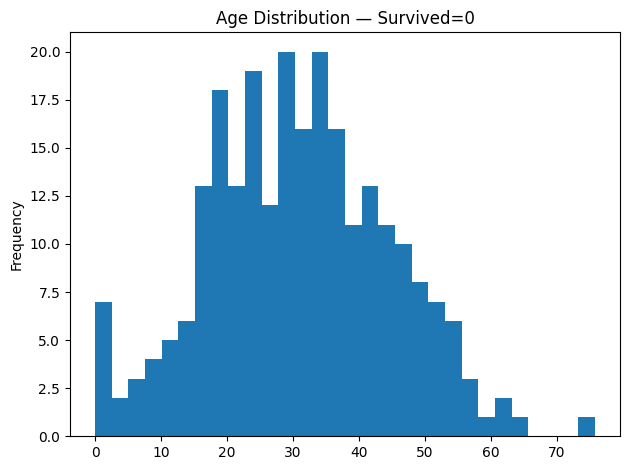

Saved figure → assets/age_hist_survived_1.png


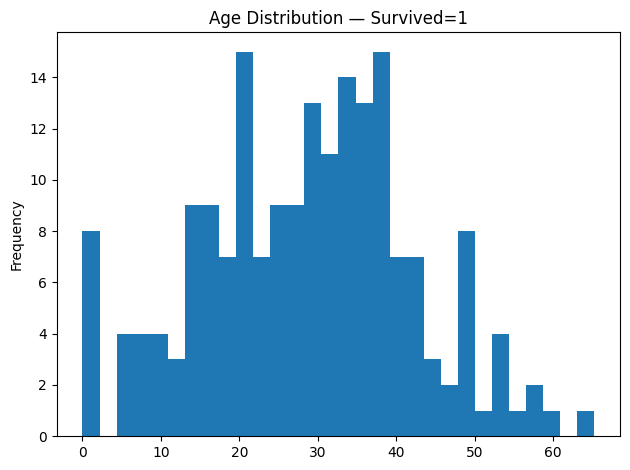

In [8]:

# Univariate example: Age histogram split by Survived (two separate plots, as requested: one chart per figure)
for k in [0,1]:
    plt.figure()
    train_df.loc[train_df[TARGET]==k,"Age"].dropna().plot.hist(bins=30)
    plt.title(f"Age Distribution — Survived={k}")
    savefig(f"assets/age_hist_survived_{k}.png")
    plt.show()


## Stage 3 — Modify
Feature engineering + preprocessing via `ColumnTransformer` inside a scikit-learn `Pipeline`.

In [ ]:

# Feature engineering pieces
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        pat = re.compile(r",\s*([A-Za-z]+)\.")
        def canon_title(t):
            t=str(t).strip().upper()
            mp={'MRS':'Mrs','MISS':'Miss','MS':'Miss','MLLE':'Miss','MME':'Mrs','MR':'Mr','MASTER':'Master',
                'DR':'Officer','REV':'Officer','COL':'Officer','MAJOR':'Officer','CAPT':'Officer',
                'SIR':'Royalty','LADY':'Royalty','COUNTESS':'Royalty','DON':'Royalty'}
            return mp.get(t, t.title() if t in {'MR','MRS','MISS','MASTER'} else 'Other')
        X["Title"]=X["Name"].map(lambda s: canon_title(pat.search(str(s)).group(1) if pat.search(str(s)) else "NA"))
        deck = X["Cabin"].astype(str).str[0]
        deck = deck.mask(X["Cabin"].isna(), "U")
        X["Deck"] = deck
        X["FamilySize"] = X["SibSp"].fillna(0) + X["Parch"].fillna(0) + 1
        X["IsAlone"] = (X["FamilySize"]==1).astype(int)
        fs = X["FamilySize"].replace(0,1)
        X["FarePerPerson"] = (X["Fare"].fillna(0)/fs).replace([np.inf,-np.inf], np.nan)
        X["Pclass_Sex"] = "P"+X["Pclass"].astype(str)+"_"+X["Sex"].astype(str)
        keep = ["Age","Fare","SibSp","Parch","FamilySize","IsAlone","FarePerPerson",
                "Sex","Embarked","Pclass","Title","Deck","Pclass_Sex",
                ID_COL,"Name","Ticket","Ticket_norm","Cabin"]
        return X[keep]

class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, cols, min_count=8, min_prop=0.01):
        self.cols=cols; self.min_count=min_count; self.min_prop=min_prop
    def fit(self, X, y=None):
        n = len(X); thr = max(self.min_count, int(np.ceil(self.min_prop*n)))
        self.keep_maps_ = {}
        for c in self.cols:
            vc = X[c].astype(str).fillna("NA").value_counts()
            self.keep_maps_[c] = set(vc[vc >= thr].index.tolist())
        return self
    def transform(self, X):
        X = X.copy()
        for c in self.cols:
            keep = self.keep_maps_.get(c, set())
            X[c] = X[c].astype(str).fillna("NA").where(X[c].astype(str).isin(keep), "RARE")
        return X

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop): self.cols_to_drop=cols_to_drop
    def fit(self, X, y=None): return self
    def transform(self, X): return X.drop(columns=self.cols_to_drop, errors="ignore")

def build_preprocessor():
    num_cols = ["Age","Fare","SibSp","Parch","FamilySize","FarePerPerson","IsAlone"]
    cat_cols = ["Sex","Embarked","Pclass","Title","Deck","Pclass_Sex"]
    prep = Pipeline([
        ("fe", FeatureEngineer()),
        ("rare", RareCategoryGrouper(cols=["Title","Deck","Embarked"], min_count=8, min_prop=0.01)),
        ("drop", ColumnDropper(cols_to_drop=[ID_COL,"Name","Ticket","Ticket_norm","Cabin"])),
        ("ct", ColumnTransformer([
            ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols),
            ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))]), cat_cols)
        ], remainder="drop", sparse_threshold=0.0))
    ])
    return prep

prep = build_preprocessor()
Xt = prep.fit_transform(train_df)
Xv = prep.transform(val_df)
Xs = prep.transform(test_df)

print("Shapes — Xt, Xv, Xs:", Xt.shape, Xv.shape, Xs.shape)

# Robust extraction of feature names (works across sklearn versions / nested pipelines)
num_cols = ["Age","Fare","SibSp","Parch","FamilySize","FarePerPerson","IsAlone"]
cat_cols = ["Sex","Embarked","Pclass","Title","Deck","Pclass_Sex"]
try:
    ct = prep.named_steps["ct"]
    cat_transformer = ct.named_transformers_.get("cat", None)
    if cat_transformer is None:
        raise RuntimeError("ColumnTransformer has no 'cat' transformer")
    # OHE may be nested in a Pipeline or be the transformer itself
    if hasattr(cat_transformer, "named_steps"):
        ohe = cat_transformer.named_steps.get("ohe", None) or list(cat_transformer.named_steps.values())[-1]
    else:
        ohe = cat_transformer
    # Try modern API then fall back to older one
    try:
        cat_names = ohe.get_feature_names_out(cat_cols)
    except Exception:
        try:
            cat_names = ohe.get_feature_names(cat_cols)
        except Exception:
            # Last-resort: infer length from transformed matrix and emit generic names
            cat_output_len = Xt.shape[1] - len(num_cols)
            cat_names = [f"cat_{i}" for i in range(cat_output_len)]
    feature_names = list(num_cols) + list(cat_names)
    print("Total features:", len(feature_names))
except Exception as e:
    feature_names = [f"f_{i}" for i in range(Xt.shape[1])]
    print("Falling back to generic feature names.", repr(e))

pd.DataFrame({"feature": feature_names}).head(10)

SyntaxError: incomplete input (3375097117.py, line 83)

## Stage 4 — Model
Baseline Logistic Regression (balanced) + RandomForest + GradientBoosting with 5-fold **StratifiedGroupKFold**.

In [ ]:

def train_cv_models(X_df, y, groups):
    models = {
        "logreg_bal": LogisticRegression(max_iter=700, class_weight="balanced", solver="lbfgs"),
        "rf": RandomForestClassifier(n_estimators=300, random_state=SEED),
        "gbdt": GradientBoostingClassifier(random_state=SEED, n_estimators=250, learning_rate=0.08, max_depth=3)
    }
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
    rows = []
    for name, est in models.items():
        oof = np.zeros(len(X_df)); seen = np.zeros(len(X_df), dtype=bool)
        for tr, te in cv.split(X_df, y, groups=groups):
            pipe = Pipeline([("prep", prep), ("model", est)])
            pipe.fit(X_df.iloc[tr], y[tr])
            proba = pipe.predict_proba(X_df.iloc[te])[:,1]
            oof[te]=proba; seen[te]=True
        rows.append({
            "model": name,
            "roc_auc_oof": float(roc_auc_score(y[seen], oof[seen])),
            "pr_auc_oof": float(average_precision_score(y[seen], oof[seen]))
        })
    return pd.DataFrame(rows).sort_values("roc_auc_oof", ascending=False)

cv_results = train_cv_models(train_df.copy(), train_df[TARGET].values, train_df["Ticket_norm"].values)
cv_results


In [ ]:

# Simple ROC-like diagnostic: show score distribution by target (one figure)
best_model_name = cv_results.iloc[0]["model"]
print("Best model:", best_model_name)

from sklearn.base import clone
best_est = {"logreg_bal": LogisticRegression(max_iter=700, class_weight="balanced", solver="lbfgs"),
            "rf": RandomForestClassifier(n_estimators=300, random_state=SEED),
            "gbdt": GradientBoostingClassifier(random_state=SEED, n_estimators=250, learning_rate=0.08, max_depth=3)}[best_model_name]

pipe = Pipeline([("prep", prep), ("model", best_est)]).fit(train_df, train_df[TARGET])
scores = pipe.predict_proba(val_df)[:,1]

plt.figure()
plt.hist(scores[val_df[TARGET]==0], bins=30, alpha=0.7, label="Negative")
plt.hist(scores[val_df[TARGET]==1], bins=30, alpha=0.7, label="Positive")
plt.title("Validation Score Distributions by Class — Best Model")
plt.legend()
savefig("assets/val_score_dist.png")
plt.show()


## Stage 5 — Assess
Calibration choice (Brier on VAL), threshold tuning (FN:FP grid), bootstrap CIs on TEST.

In [ ]:

# Calibrate on validation
y_val = val_df[TARGET].values
cal_sig = CalibratedClassifierCV(pipe, method="sigmoid", cv="prefit").fit(val_df, y_val)
cal_iso = CalibratedClassifierCV(pipe, method="isotonic", cv="prefit").fit(val_df, y_val)
p_sig = cal_sig.predict_proba(val_df)[:,1]; p_iso = cal_iso.predict_proba(val_df)[:,1]
b_sig = brier_score_loss(y_val, p_sig); b_iso = brier_score_loss(y_val, p_iso)
cal = cal_iso if b_iso < b_sig else cal_sig
cal_name = "isotonic" if b_iso < b_sig else "sigmoid"
print("Chosen calibrator:", cal_name)


In [ ]:

# Threshold tuning grid (VAL)
ratios=[(1,1),(1,2),(1,3),(1,5)]
ths=np.linspace(0.05,0.95,19)
p_val = cal.predict_proba(val_df)[:,1]

def cost(y,p,t,cfp=1,cfn=2):
    yhat=(p>=t).astype(int)
    fp=((yhat==1)&(y==0)).sum(); fn=((yhat==0)&(y==1)).sum()
    return cfp*fp + cfn*fn

thr = { f"{cfp}:{cfn}": float(ths[np.argmin([cost(y_val,p_val,t,cfp,cfn) for t in ths])]) for (cfp,cfn) in ratios }
thr


In [ ]:

# TEST evaluation + bootstrap CIs
y_test = test_df[TARGET].values
p_test = cal.predict_proba(test_df)[:,1]

rng=np.random.default_rng(123); idx=np.arange(len(y_test))
def boot_ci(fn, B=300):
    vals=[ fn(*(lambda s:(y_test[s],p_test[s]))(rng.choice(idx,size=len(idx),replace=True)) ) for _ in range(B) ]
    return float(np.mean(vals)), float(np.percentile(vals,2.5)), float(np.percentile(vals,97.5))

roc = boot_ci(lambda y,p: roc_auc_score(y,p))
pr  = boot_ci(lambda y,p: average_precision_score(y,p))

thr_star = list(thr.values())[1]  # e.g., 1:2 setting
f1  = boot_ci(lambda y,p: f1_score(y,(p>=thr_star).astype(int)))
acc = boot_ci(lambda y,p: accuracy_score(y,(p>=thr_star).astype(int)))
brier = boot_ci(lambda y,p: brier_score_loss(y,p))

def ece10(y,p):
    bins=np.linspace(0,1,11); ids=np.digitize(p,bins)-1; e=0.0
    for b in range(10):
        m=ids==b
        if np.any(m): e += abs((y[m].mean()-p[m].mean()))*(m.mean())
    return e
ece = boot_ci(ece10)

print(json.dumps({
    "roc_auc_mean_ci": roc,
    "pr_auc_mean_ci": pr,
    "f1_thr_mean_ci": f1,
    "acc_thr_mean_ci": acc,
    "brier_mean_ci": brier,
    "ece10_mean_ci": ece
}, indent=2))


In [ ]:

# Simple reliability diagram (calibration) — single chart
bins = np.linspace(0,1,11)
ids = np.digitize(p_test, bins) - 1
x, y = [], []
for b in range(10):
    m = ids==b
    if np.any(m):
        x.append(p_test[m].mean())
        y.append(y_test[m].mean())
plt.figure()
plt.plot([0,1],[0,1])
plt.scatter(x,y)
plt.title("Reliability Diagram — Test")
savefig("assets/reliability_test.png")
plt.show()


### Done
Artifacts saved under `./assets/` and key JSON under `./reports/` (in-memory only unless you save them yourself).